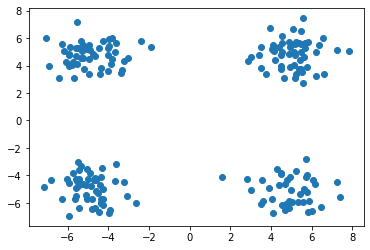

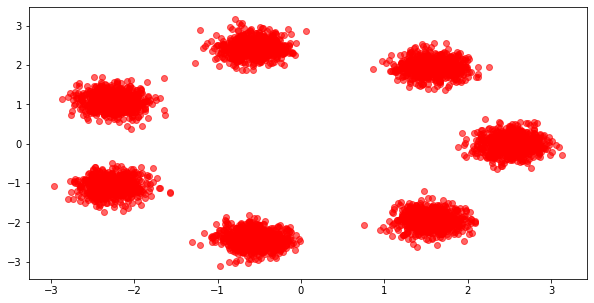

In [55]:
import torch 
import pyro
mean = torch.tensor([[5.,5.],[-5.,-5.],[-5.,5.],[5.,-5.]])
cov = torch.eye(2).unsqueeze(0).repeat(4,1,1)
weights = torch.tensor([.25,.25,.25,.25])
cat = torch.distributions.Categorical(weights)
mvn = torch.distributions.MultivariateNormal(mean, cov)
mix = torch.distributions.MixtureSameFamily(cat, mvn)
x = mix.sample([200])
import matplotlib.pyplot as plt
plt.scatter(x[:,0].numpy(), x[:,1].numpy())

from targets.density_estimation_target import Orbits
target= Orbits()
x = target.sample(1000)
target.target_visual()

In [56]:
from IPython.display import clear_output

In [57]:
#prior_parameters
d=2
nu = 2
lbda = 2
mu = torch.zeros(d)
psi = torch.eye(d)
alpha = 1

In [58]:
def compute_posterior_parameters(x):
    N = x.shape[0]
    empirical_mean = torch.mean(x, dim =0)
    mu_N = (lbda*mu + N*empirical_mean)/(lbda + N)
    S = torch.cov(x.T)*(N-1) if N>=2 else torch.zeros(d)
    temp = (empirical_mean-mu).unsqueeze(-1)
    psi_N = psi + S + (lbda*N*temp@temp.T)/(lbda + N)
    return nu + N, lbda + N, mu_N, psi_N
    


def compute_probability(x,z,i):
    z_i = torch.cat([z[:i], z[i+1:]], dim =0)
    list_weight = []
    list_evaluated_prob=[]
    for c in torch.unique(z_i):
        extracted = x[z==c]
        nu_n_c, lbda_n_c, mu_n_c, psi_n_c = compute_posterior_parameters(extracted)
        list_weight.append(extracted.shape[0]/(x.shape[0]-1+alpha))
        list_evaluated_prob.append(torch.exp(pyro.distributions.MultivariateStudentT(nu_n_c-d+1,mu_n_c,torch.cholesky(psi_n_c*(lbda_n_c+1)/(lbda_n_c*(nu_n_c - d + 1)))).log_prob(x[i,:])))
    list_evaluated_prob.append(torch.exp(pyro.distributions.MultivariateStudentT(nu-d+1,mu,torch.cholesky(psi*(lbda+1)/(lbda*(nu - d + 1)))).log_prob(x[i,:])))                               
    list_weight.append(alpha/(x.shape[0]-1+alpha))
    probs = torch.tensor(list_weight)*torch.tensor(list_evaluated_prob)
    return probs    

torch.Size([175])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


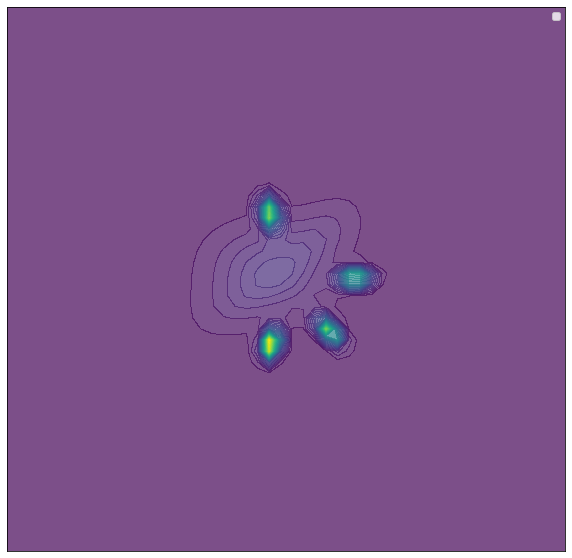

In [ ]:
z = torch.randint(size=[x.shape[0]],high = x.shape[0])
for t in range(100):
    clear_output(wait=True)
    for i in range(x.shape[0]):
        prob = compute_probability(x,z,i)
        z[i] = torch.distributions.Categorical(prob/torch.sum(prob)).sample()
    print(torch.unique(z).shape)
    plot_2d_function(lambda samples: log_prob(samples,x,z), levels = 50, delta = 50,new_figure = True)
    plt.show()

In [23]:
def log_prob(new_x,x,z):
    list_weight = []
    list_evaluated_prob=[]
    for c in torch.unique(z):
        extracted = x[z==c]
        nu_n_c, lbda_n_c, mu_n_c, psi_n_c = compute_posterior_parameters(extracted)
        list_weight.append(extracted.shape[0]/(x.shape[0]))
        list_evaluated_prob.append(torch.exp(pyro.distributions.MultivariateStudentT(nu_n_c-d+1,mu_n_c,torch.cholesky(psi_n_c*(lbda_n_c+1)/(lbda_n_c*(nu_n_c - d + 1)))).log_prob(new_x)).unsqueeze(-1))
        temp  = torch.exp(pyro.distributions.MultivariateStudentT(nu_n_c-d+1,mu_n_c,torch.cholesky(psi_n_c*(lbda_n_c+1)/(lbda_n_c*(nu_n_c - d + 1)))).log_prob(new_x))
    probs = torch.sum(torch.tensor(list_weight).unsqueeze(0)*torch.cat(list_evaluated_prob, dim=1), dim= -1)
    return probs  
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


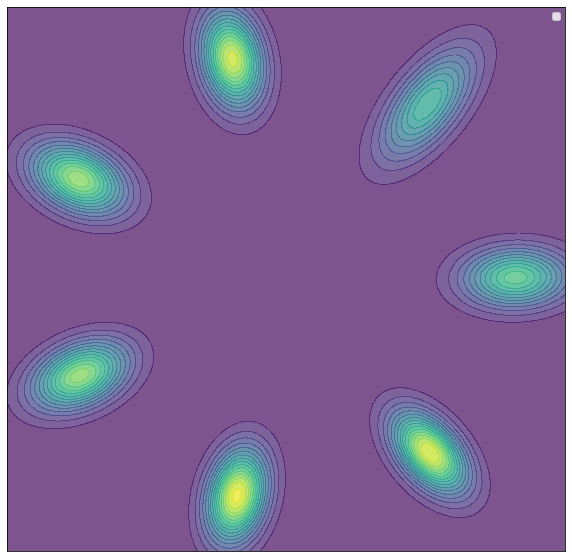

In [60]:
import matplotlib
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)
        plt.legend()

plot_2d_function(lambda samples: log_prob(samples,x,z),x_min = -3,x_max = 3, y_min = -3, y_max = 3, levels = 20)

In [61]:
print(torch.unique(z).shape)

torch.Size([14])
